<a href="https://colab.research.google.com/github/cirilwakounig/AlgorithmicTrading/blob/main/2_1_Stock_Portfolio_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Portfolio Optimisation using the Efficient Frontier Approach**

---




This programme attempts to optimise a users portfolio using the Efficient Frontier. It has been created by following the tutorial found at: https://www.youtube.com/watch?v=9fjs8FeLMJk&ab_channel=ComputerScience

Information about the efficient frontier can be found at: 
https://www.youtube.com/watch?v=OOj6ihAwdCo&ab_channel=BigThink


In [1]:
# Import required Libraries
from pandas_datareader import data as web
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
# Get the Stock Symbols / Tickers in the Portfolio
# FAANG
assets = ["FB", "AMZN", "AAPL", "NFLX", "TSLA"]

In [3]:
# Assign weights to the stocks 
weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

In [4]:
# Get the portfolio start date 
stockStartDate = '2013-01-01'
# Get the portfolio ending date (today)
today = datetime.today().strftime('%Y-%m-%d')
today

'2020-12-26'

In [5]:
# Create the data frame to store the adjusted close price for the stocks
df = pd.DataFrame()

# Store the adjusted close prices in the data frame
for stock in assets: 
  df[stock] = web.DataReader(stock, data_source='yahoo', start = stockStartDate, end = today)["Adj Close"]
  

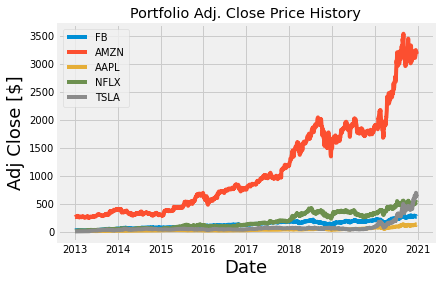

In [6]:
# Plot the Selected Stocks
title = 'Portfolio Adj. Close Price History'

# Get the stocks
my_stocks = df

# Create and plot the graphs
for cols in my_stocks.columns.values:
  plt.plot(my_stocks[cols], label = cols)

plt.title(title)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Adj Close [$]', fontsize = 18)
plt.legend(my_stocks.columns.values, loc ='upper left') 
plt.show()

In [7]:
# The daily rate of return is calculated below - Note that numbers are not in percentage yet!
# Daily returns are calculated as the new price divided by the old price minus one  
returns = df.pct_change()
returns

,FB,AMZN,AAPL,NFLX,TSLA
Date,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.008214,0.004547,-0.012622,0.049777,-0.016686
2013-01-04,0.035650,0.002592,-0.027855,-0.006315,-0.010641
2013-01-07,0.022949,0.035925,-0.005882,0.033549,-0.001744
2013-01-08,-0.012237,-0.007748,0.002692,-0.020565,-0.019220
...,...,...,...,...,...
2020-12-18,0.006995,-0.010639,-0.015851,0.002909,0.059613
2020-12-21,-0.013061,0.001415,0.012395,-0.010366,-0.064950
2020-12-22,-0.020895,0.000106,0.028465,-0.002987,-0.014649


In [8]:
# Create and show the annualised covariance matrix
# The diagonal elements within the matrix show the variance of each individual stock
cov_matrix_annual = returns.cov() * 252       # times 252 is the number of trading days
cov_matrix_annual

,FB,AMZN,AAPL,NFLX,TSLA
FB,0.118793,0.055042,0.044695,0.056694,0.058256
AMZN,0.055042,0.094141,0.039764,0.063413,0.056849
AAPL,0.044695,0.039764,0.081719,0.035091,0.049849
NFLX,0.056694,0.063413,0.035091,0.211059,0.074687
TSLA,0.058256,0.056849,0.049849,0.074687,0.315379


## **Portfolio Performance Metrics**


---



Information about this can be found here: https://blog.quantinsti.com/calculating-covariance-matrix-portfolio-variance/

In [9]:
# Calculate the portfolio variance
port_variance = np.dot(weights.T, np.dot(cov_matrix_annual, weights))
port_variance

0.07559085546331754

In [10]:
# Calculate the Portfolio Volatility (Standard Deviation)
# Volatility is the square root of the variance
port_volatility = np.sqrt(port_variance)
port_volatility

0.2749379120152722

In [11]:
# Annual Portfolio Return based on the daily mean for each stock, times their weight
# multiplied by the number of trading days per year (252)
portfolioSimpleAnnualReturn = np.sum(returns.mean()*weights)*252
portfolioSimpleAnnualReturn

0.4578284568629028

In [12]:
# Show the expected variance, volatility (risk) and annual return of the portfolio
percent_var = str(round(port_variance,2) * 100)  + "%"
percent_vol = str(round(port_volatility,2) * 100) + "%"
percent_ret = str(round(portfolioSimpleAnnualReturn,2)*100) + "%"

print("Expected Annual Return: ",percent_ret)
print("Annual Volatility/Risk: ", percent_vol)
print("Annual Variance: ", percent_var)


Expected Annual Return:  46.0%
Annual Volatility/Risk:  27.0%
Annual Variance:  8.0%


## **Portfolio Optimisation**

---



In [13]:
# Install Portfolio Optimisation Package
!pip install PyPortfolioOpt

In [14]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [15]:
# Calculate the Expected Returns and the Annualised Sample Covariance Matrix of Assets
mu = expected_returns.mean_historical_return(df, frequency = 252) # returns.mean() * 252

# Develop the Covariance matrix for the sample assets
S = risk_models.sample_cov(df)

In [16]:
# Optimise for Maximum Sharpe Ratio
# https://www.investopedia.com/terms/s/sharperatio.asp

# Develop the efficient frontier
ef = EfficientFrontier(mu, S)

# Obtain the raw weights for a maximised Sharpe Ratio
weights = ef.max_sharpe()
# Unnecessary stocks are removed under a certain cutoff point of the weights
# Note that the sum of weights will probably not result exactly equal to one
cleaned_weights = ef.clean_weights()
print(cleaned_weights)
ef.portfolio_performance(verbose = True)  # Verbose = True gives a longer output

OrderedDict([('FB', 0.02025), ('AMZN', 0.2202), ('AAPL', 0.19016), ('NFLX', 0.27897), ('TSLA', 0.29042)])
Expected annual return: 52.9%
Annual volatility: 30.4%
Sharpe Ratio: 1.67


(0.5291350397912244, 0.30410215993940215, 1.6742236881601853)

In [17]:
# Final step: Finding out the amount of shares to buy per stock
# Get the discrete allocation of each share per stock
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(df)
weights = cleaned_weights
# Discrete Allocation - Assuming that we are prepared to invest 15000 $
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value = 15000)

allocation, leftover = da.lp_portfolio()
print('Discrete allocation:', allocation)
print('Funds remaining: ${:.2f}'.format(leftover))

Discrete allocation: {'FB': 1, 'AMZN': 1, 'AAPL': 21, 'NFLX': 8, 'TSLA': 7}
Funds remaining: $44.39


In [18]:
latest_prices

FB       267.399994
AMZN    3172.689941
AAPL     131.970001
NFLX     513.969971
TSLA     661.770020
Name: 2020-12-24 00:00:00, dtype: float64